In [1]:
#Installing/Importing all the necessary libraries
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from tensorflow.keras.utils import to_categorical
from tifffile import imsave
import tensorflow as tf

-We'll do Z-score normalization to make the data uniform and remove the effect of anisotropy (the output images has zero mean and unit variance)

-To detect the tumor area in each slice we will
1. All the modalities except the T1 and Compute the Z-xcore normalized image
2. Binarize the obtained image
3. Apply morphological operator to remove some irrelevant areas
4. Multiply both binary images of FLAIR and T2
5. Combined T1ce and the dot product of FLAIR and T2

In [2]:
TRAIN_DATASET_PATH = r'C:\Users\yashv\Downloads\BraTS2020_TrainingData (1)\MICCAI_BraTS2020_TrainingData'
img_1 = nib.load(TRAIN_DATASET_PATH + r'\BraTS20_Training_002\BraTS20_Training_002_flair.nii').get_fdata()
# print(img_1)

#Z-SCORE NORMALIZATION (ONLY WHERE BRAIN IS PRESENT)

# Mask the array to include only values > 0
mask = img_1 > 0
# print(mask.shape)
brain_values = img_1[mask] 
# print(brain_values.shape) 1-D array


mean = np.mean(brain_values)
std_dev = np.std(brain_values)
print(f"Mean: {mean}, Std Dev: {std_dev}")

img_1[mask] = (img_1[mask] - mean) / std_dev

Mean: 286.4880593659815, Std Dev: 93.4229833189248


In [3]:
TRAIN_DATASET_PATH=r'C:\Users\yashv\Downloads\BraTS2020_TrainingData (1)\MICCAI_BraTS2020_TrainingData'
img_1=nib.load(TRAIN_DATASET_PATH+'\BraTS20_Training_002\BraTS20_Training_002_flair.nii').get_fdata()
mask=img_1>0
brain=img_1[mask]
mean = np.mean(brain)
std_dev = np.std(brain)
print(mean, std_dev)
img_1[mask] = (img_1[mask] - mean) / std_dev
# print(img_1)

img_2=nib.load(TRAIN_DATASET_PATH+'\BraTS20_Training_002\BraTS20_Training_002_t1.nii').get_fdata()
mask=img_2>0
brain=img_2[mask]
mean = np.mean(brain)
std_dev = np.std(brain)
print(mean, std_dev)
img_2[mask] = (img_2[mask] - mean) / std_dev

img_3=nib.load(TRAIN_DATASET_PATH+'\BraTS20_Training_002\BraTS20_Training_002_t1ce.nii').get_fdata()
mask=img_3>0
brain=img_3[mask]
mean = np.mean(brain)
std_dev = np.std(brain)
print(mean, std_dev)
img_3[mask] = (img_3[mask] - mean) / std_dev

img_4=nib.load(TRAIN_DATASET_PATH+'\BraTS20_Training_002\BraTS20_Training_002_t2.nii').get_fdata()
mask=img_4>0
brain=img_4[mask]
mean = np.mean(brain)
std_dev = np.std(brain)
print(mean, std_dev)
img_4[mask] = (img_4[mask] - mean) / std_dev

img_5=nib.load(TRAIN_DATASET_PATH+'\BraTS20_Training_002\BraTS20_Training_002_seg.nii').get_fdata()
# mask=img_5>0
# brain=img_5[mask]
# mean = np.mean(brain)
# std_dev = np.std(brain)
# print(mean, std_dev)
# img_5[mask] = (img_5[mask] - mean) / std_dev

286.4880593659815 93.4229833189248
411.14151265789064 99.46981809593119
444.8883366532441 115.30651148150334
190.38415705342268 69.9309134170823


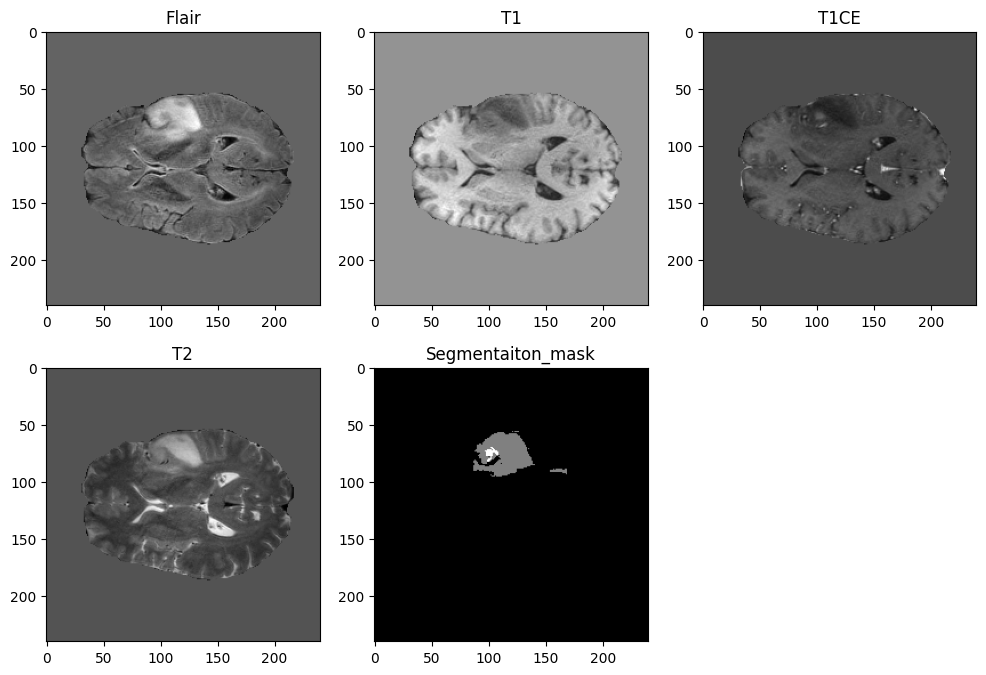

In [4]:
plt.figure(figsize=(12,8))
n=70
plt.subplot(231)
plt.imshow(img_1[:,:,n], cmap='gray')
plt.title('Flair')

plt.subplot(232)
plt.imshow(img_2[:,:,n], cmap='gray')
plt.title('T1')

plt.subplot(233)
plt.imshow(img_3[:,:,n], cmap='gray')
plt.title('T1CE')

plt.subplot(234)
plt.imshow(img_4[:,:,n], cmap='gray')
plt.title('T2')

plt.subplot(235)
plt.imshow(img_5[:,:,n], cmap='gray')
plt.title('Segmentaiton_mask')
plt.show()

In [5]:
#Converting the image to a binary image (0/1)
img_1= (img_1 >=0.7).astype(np.uint8)
img_2= (img_2 >=0.7).astype(np.uint8)
img_3= (img_3 >=0.9).astype(np.uint8)
img_4= (img_4 >=0.7).astype(np.uint8)
# img_5= (img_5 >=0.7).astype(np.uint8)

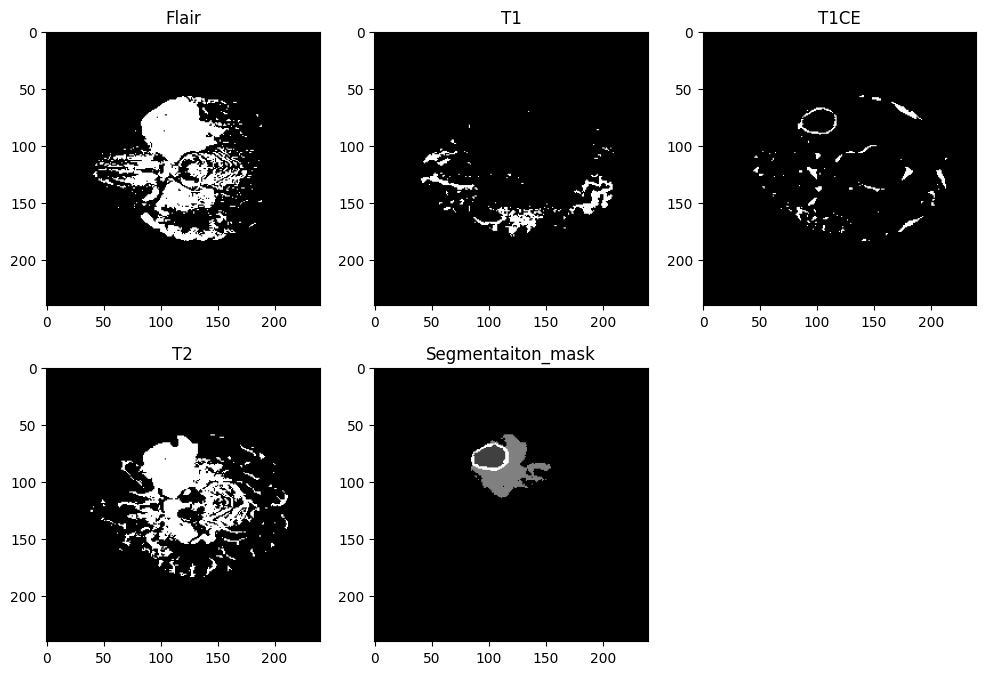

In [6]:
plt.figure(figsize=(12,8))
n=50
plt.subplot(231)
plt.imshow(img_1[:,:,n], cmap='gray')
plt.title('Flair')

plt.subplot(232)
plt.imshow(img_2[:,:,n], cmap='gray')
plt.title('T1')

plt.subplot(233)
plt.imshow(img_3[:,:,n], cmap='gray')
plt.title('T1CE')

plt.subplot(234)
plt.imshow(img_4[:,:,n], cmap='gray')
plt.title('T2')

plt.subplot(235)
plt.imshow(img_5[:,:,n], cmap='gray')
plt.title('Segmentaiton_mask')
plt.show()

In [7]:
#Taking the dot product of flair and T2
dot_product = img_1* img_4
# print(dot_product)
print(np.sum(dot_product))
mask=dot_product>0.4
print(np.sum(mask))

128890
128890


In [8]:
#Finding the length of major axis
from skimage.measure import label, regionprops
props = regionprops(img_3[:,:,100])#100th Slice of T1ce
for region in props:
        major_axis_length = region.major_axis_length
if major_axis_length>10:
        print('Length of the axis is greater than 10 pixels')


Length of the axis is greater than 10 pixels


-Tumor in FLAIR and T2 images is demonstrated with a higher intensity thant other parts of the brain

-Tumor is much brighter in T1ce than FLAIR and T2 images (therefore a bigger value for binarization i.e 0.9)

-We'll apply extra constraints to the binarized T1ce images

In [9]:
t1_list = sorted(glob.glob(r'C:\Users\yashv\Downloads\BraTS2020_TrainingData (1)\MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob(r'C:\Users\yashv\Downloads\BraTS2020_TrainingData (1)\MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob(r'C:\Users\yashv\Downloads\BraTS2020_TrainingData (1)\MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob(r'C:\Users\yashv\Downloads\BraTS2020_TrainingData (1)\MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob(r'C:\Users\yashv\Downloads\BraTS2020_TrainingData (1)\MICCAI_BraTS2020_TrainingData/*/*seg.nii'))
print(len(t2_list),len(t1ce_list),len(flair_list),len(mask_list))

369 369 369 369


In [10]:
from skimage.measure import label, regionprops
for img in range(len(t2_list)):
    print(img)
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3

    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_flair=nib.load(flair_list[img]).get_fdata()

    #Z-normalization and binarization of the image
    mask=temp_image_t2>0
    brain=temp_image_t2[mask]
    mean = np.mean(brain)
    std_dev = np.std(brain)
    # print(mean, std_dev)
    temp_image_t2[mask] = (temp_image_t2[mask] - mean) / std_dev
    temp_image_t2=(temp_image_t2 > 0.7).astype(np.uint8)

    mask=temp_image_t1ce>0
    brain=temp_image_t1ce[mask]
    mean = np.mean(brain)
    std_dev = np.std(brain)
    # print(mean, std_dev)
    temp_image_t1ce[mask] = (temp_image_t1ce[mask] - mean) / std_dev
    temp_image_t1ce=(temp_image_t1ce > 0.9).astype(np.uint8)

    mask=temp_image_flair>0
    brain=temp_image_flair[mask]
    mean = np.mean(brain)
    std_dev = np.std(brain)
    # print(mean, std_dev)
    temp_image_flair[mask] = (temp_image_flair[mask] - mean) / std_dev
    temp_image_flair=(temp_image_flair > 0.7).astype(np.uint8)

    #DOT Product of Flair and T2
    dot_product=temp_image_flair*temp_image_t2

    # Initialize lists to collect slices
    T1B_list = []
    FT2B_list = []
    Mask_list=[]

    for i in range(155):
    # Get region properties for the current slice
        props = regionprops(temp_image_t1ce[:, :, i])
    
    # Check for regions and their major axis length
        major_axis_length = 0  # Default value if no regions are found
        for region in props:
            major_axis_length = region.major_axis_length
        if major_axis_length > 35: #As given in the paper
            if (np.sum(dot_product[:, :, i]) >= 400) & (np.sum(temp_image_t1ce[:, :, i]) >= 100):
                T1B_list.append(temp_image_t1ce[:, :, i])  
                FT2B_list.append(dot_product[:, :, i])   
                Mask_list.append(temp_mask[:,:,i])  
    if len(T1B_list)>0:
        T1B = np.stack(T1B_list, axis=2)
        # print(T1B.shape)
        FT2B = np.stack(FT2B_list, axis=2)
        # print(FT2B.shape)
        Mask=np.stack(Mask_list, axis=2)
        # print(Mask.shape)
        combined_image=np.stack((T1B, FT2B),axis=3)
        # print(combined_image.shape)

        Mask= to_categorical(Mask, num_classes=4)
        np.save(r'C:/Users/yashv/Downloads/BraTS2020_TrainingData (1)/input_data_3channels/images/image_'+str(img)+'.npy', combined_image)
        np.save(r'C:/Users/yashv/Downloads/BraTS2020_TrainingData (1)/input_data_3channels/masks/mask_'+str(img)+'.npy', Mask)
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27